 # Преобразование данных в альфа-факторы

Основываясь на понимании ключевых альфа-факторов и популярных показателях определяются новые альфа-факторы, которые буду иметь лучшее соотношение риск-доходность

Создание набора данных и сохранение для повторного использования

## Получение данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
from pyfinance.ols import PandasRollingOLS



In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
START = 2000
END = 2019

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [8]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


## Сохранение данных и подготовка для сопоставления

In [9]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'
stocks

,marketcap,ipoyear,sector
ticker,,,
PIH,4.309000e+07,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,7.033000e+07,NaN,Finance
FLWS,8.333900e+08,1999.0,Consumer Services
FCCY,1.781400e+08,NaN,Finance
...,...,...,...
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation


In [10]:
shared = prices.columns.intersection(stocks.index)

In [11]:
shared

Index(['A', 'AA', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT',
       ...
       'ZEN', 'ZEUS', 'ZGNX', 'ZION', 'ZIOP', 'ZIXI', 'ZNGA', 'ZOES', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=2412)

In [12]:
stocks = stocks.loc[shared, :]
stocks

,marketcap,ipoyear,sector
ticker,,,
A,1.960000e+10,1999.0,Capital Goods
AA,8.540000e+09,2016.0,Basic Industries
AAL,1.767000e+10,NaN,Transportation
AAMC,1.104900e+08,NaN,Finance
AAN,3.200000e+09,NaN,Technology
...,...,...,...
ZIXI,2.944800e+08,NaN,Technology
ZNGA,3.550000e+09,2011.0,Technology
ZOES,1.974000e+08,2014.0,Consumer Services


In [13]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [14]:
assert prices.shape[1] == stocks.shape[0]

## Создание данных по месяцным доходностям

Для сокращения времени обучения и дальнеших исследований на более длительных временных горизонтах, производится преобразование данных о доходности с частотой на конец каждого месяца с использованием Adj Close цены

In [15]:
monthly_prices = prices.resample('M').last()

In [16]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


Зафиксируем динамику изменения цены во времени, что поможет отобразить, например, паттерны ценовых импульсов. Для этого расчитывается ежемесячные данные исторической доходности на интервалах в месяцах, пeреданных в переменной lags с использованием метода .pct_change(n_periods)

Результаты конвертируем в длинный формат, где каждый месяц для каждого тикера будут отображаться доходности за указанные в lags отрезки времени в месяцах с помощью .stack(), с помощью .pipe применяя .clip() отсекаем выбросы из оставляем только значения доходностей от 1% до 99% 

Затем нормализуем данные с помощью среднего геометрического. После используем .swaplevel() для изменения порядка расположения индексов первыми тикеры - после дата

In [17]:
outlier_cutoff = .01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices.pct_change(lag)
                                            .stack()
                                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                                  upper=x.quantile(1-outlier_cutoff)))
                                              .add(1)
                                              .pow(1/lag)
                                              .sub(1))
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399525 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   399525 non-null  float64
 1   return_2m   399525 non-null  float64
 2   return_3m   399525 non-null  float64
 3   return_6m   399525 non-null  float64
 4   return_9m   399525 non-null  float64
 5   return_12m  399525 non-null  float64
dtypes: float64(6)
memory usage: 19.8+ MB


### Удаление данных по акция и историческими данными о доходности менне 10 лет

In [18]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
data = data.loc[keep]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 17.9+ MB


## Сводные данные по доходности на рынке акций

In [19]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


### Значения корреляции по периодам 

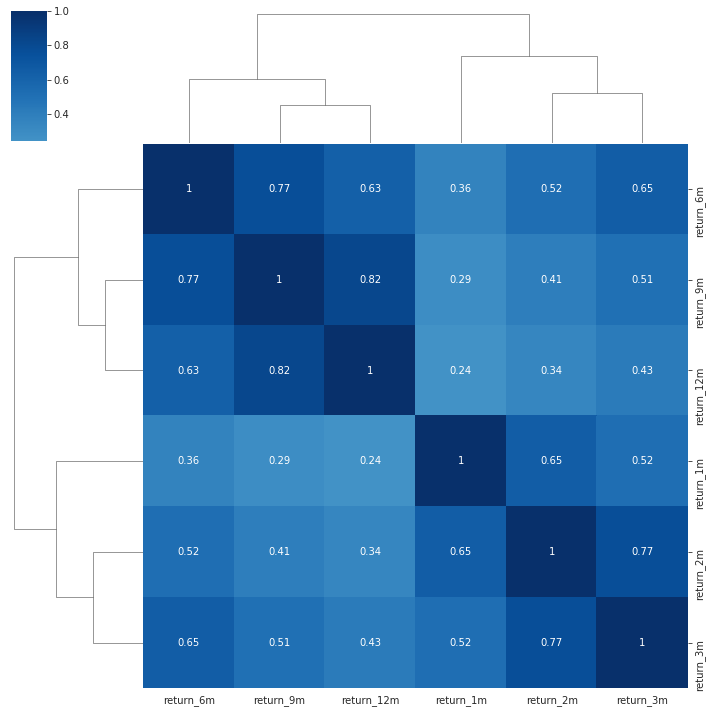

In [20]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues')

Итоговое количество тикеров

In [21]:
data.index.get_level_values('ticker').nunique()

1838

## Исследование бета-факторов

Данные Fama-French могут быть использованы для оценки подверженности активов общим рискам

Факторы Fama-French: рыночный риск, размер, стоимость, операционная прибыльность и инвестиции обычно имеют эмпирическую зависимость с доходностью актива и могут быть использованы для оценки риск профиля к доходности портфеля. Следовательно, разумно использование данных факторов в качестве финансовых характеристик модели для прогнозирование будущей доходности. 

Получение и оценка исторических значений факторов возможны с помощью `pandas-datareader`.

In [22]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-31 to 2020-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


In [23]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 17.9+ MB


In [24]:
T = 24
betas = (factor_data.
                    groupby(level='ticker', group_keys=False).
                    apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [25]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000
mean,0.981852,0.628170,0.128163,-0.059209,0.013730,1.692706
std,0.918801,1.248064,1.615946,1.919871,2.182699,3.454764
min,-9.922641,-10.212033,-17.654894,-22.925165,-18.182706,-31.429456
25%,0.465436,-0.114603,-0.710337,-0.979134,-1.086916,-0.088592
50%,0.932070,0.543000,0.101905,0.039257,0.032829,1.632188
75%,1.447382,1.303498,0.955347,0.955350,1.140405,3.456170
max,10.916430,10.373043,14.558920,17.413382,17.626042,33.316296


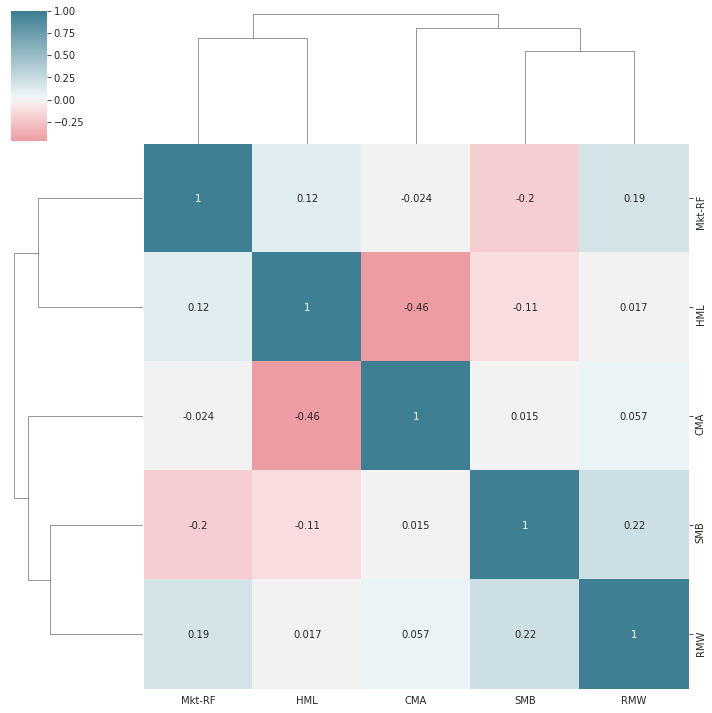

In [26]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [27]:
data = (data.join(betas.groupby(level='ticker').shift()))

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 41.7+ MB


Заполнение пропущенных значений

In [29]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 41.7+ MB
